# Problem 2.2 (c)

(Potato in a stew) What is the equilibrium shape of a $0.0042\,\mathrm{\mu m}^3$ volume of $\mathrm{Al_2SiO_5}$ in free space (stress-free boundaries)? Take the surface energy, $\gamma$, to be equal to $200\,\mathrm{mJ/m^2}$. The crystalline axes a, b, and c are aligned with the x, y, and z-axes of a Cartesian lab coordinate system.

## imports

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [4]:
from scipy import fftpack

## mesh

The interface width W between approximately $\varphi = 0.1$ and $\varphi = 0.9$ in this model is given by $W = 2\sqrt{2\kappa/h_0}$, while $\gamma = \sqrt{\kappa h_0/18}$, $\kappa = 1.5\gamma W$, and $h_0 = 12\gamma/W$ (ignoring modification of the phase field order parameter $\varphi$ by the elastic interactions through the interface). Use $\kappa = 3\times 10^{-9}\,\mathrm{J/m}$, and $h_0 = 2.4\times 10^{8}\,\mathrm{J/m^3}$.

In [5]:
kappa = fp.Variable("3e-9 J/m")

In [6]:
h0 = fp.Variable("2.4e8 J/m**3")

In [7]:
W = 2*nmx.sqrt(2*kappa/h0)

In [8]:
print W

1e-08 m


strip away the dimensions

In [9]:
h0 = h0.value.value
kappa = kappa.value.value

In [10]:
dx = 1e-8 / 5

In [11]:
Lx = .4e-6

In [12]:
print (4./3)*nmx.pi*fp.Variable("0.155 mum")*fp.Variable("0.042 mum")*fp.Variable("0.155 mum")

0.00422669875614 mum**3


In [13]:
mesh = fp.Grid2D(dx=dx, Lx=Lx, dy=dx, Ly=Lx) + [[-Lx/2.], [-Lx/2.]]

### reciprocal lattice vector

In [14]:
g = fp.CellVariable(mesh=mesh, name=r"$\vec{g}$", rank=1)
g.value.shape = (-1, g.mesh.nx, g.mesh.nx)
g.value[0] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)
g.value[1] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis]
g.value.shape = (-1, g.mesh.numberOfCells)

## solution variables

In [15]:
phase = fp.CellVariable(mesh=mesh, name=r"$\varphi$", value=0., hasOld=True)

In [16]:
h = phase**3 * (6*phase**2 - 15*phase + 10)

## material properties

### lattice parameters

In [17]:
a = 7.738e-10
b = 7.857e-10
c = 5.534e-10

In [18]:
am = bm = 7.6918e-10
cm = 5.5674e-10

The crystallographic misfit strain tensor $\epsilon_{ij}^T$ is
$$\epsilon_{ij}^T 
= \left(\begin{matrix}
\frac{a-a_m}{a_m} & 0 & 0 \\
0 & \frac{b-b_m}{b_m} & 0 \\
0 & 0 & \frac{c-c_m}{c_m}
\end{matrix}\right)$$

**note:** These are the *magnitudes*. 

In [19]:
misfit = nmx.zeros((2,2))
misfit[0][0] = (a - am) / am
misfit[1][1] = (b - bm) / bm

### homogeneous strain

In [20]:
homostrain = nmx.zeros((2,2))

### stiffness tensor

In [21]:
C = {'inclusion': dict(), 'matrix': dict()}

C['inclusion'][11] = 233.4e9
C['inclusion'][22] = 289.0e9
C['inclusion'][33] = 380.1e9
C['inclusion'][44] =  99.5e9
C['inclusion'][55] =  87.8e9
C['inclusion'][66] = 112.3e9
C['inclusion'][12] = (233.4e9 - C['inclusion'][11] - C['inclusion'][22]) / 2.
C['inclusion'][13] = (380.9e9 - C['inclusion'][11] - C['inclusion'][33]) / 2.
C['inclusion'][23] = (506.3e9 - C['inclusion'][22] - C['inclusion'][33]) / 2.

C['matrix'][11] = C['matrix'][22] = 269.0e9
C['matrix'][33] = 480.0e9
C['matrix'][44] = C['matrix'][55] = 124.0e9
C['matrix'][66] = 192.0e9
C['matrix'][12] = 177.0e9
C['matrix'][13] = C['matrix'][23] = 146.0e9

for material in ('inclusion', 'matrix'):
    C[material]['ijkl'] = nmx.zeros((2, 2, 2, 2))
    Cijkl = C[material]['ijkl']
    
    # Uncompressing the Voigt notation:
    
    Cijkl[0][0][0][0] = C[material][11]
    Cijkl[1][1][1][1] = C[material][22]
    # Cijkl[2][2][2][2] = C[material][33]
    Cijkl[0][0][1][1] = Cijkl[1][1][0][0] = C[material][12]
    # Cijkl[0][0][2][2] = Cijkl[2][2][0][0] = C[material][13]
    # Cijkl[1][1][2][2] = Cijkl[2][2][1][1] = C[material][23]
    # Cijkl[1][2][1][2] = Cijkl[2][1][2][1] = Cijkl[1][2][2][1] = Cijkl[2][1][1][2] = C[material][44]
    # Cijkl[0][2][0][2] = Cijkl[2][0][2][0] = Cijkl[0][2][2][0] = Cijkl[2][0][0][2] = C[material][55]
    Cijkl[0][1][0][1] = Cijkl[1][0][1][0] = Cijkl[0][1][1][0] = Cijkl[1][0][0][1] = C[material][66]
    
C['delta'] = C['matrix']['ijkl'] - C['inclusion']['ijkl']
C['phase'] = C['inclusion']['ijkl'] * h + C['matrix']['ijkl'] * (1-h)

# elasticity

Following the iterative FFT stress calculation method of

> A PHASE-FIELD MODEL FOR EVOLVING MICROSTRUCTURES WITH STRONG ELASTIC INHOMOGENEITY  
> S. Y. HU and L. Q. CHEN  
> _Acta mater._ **49** (2001) 1879–1890

let us expand about the properties of the inclusion.

The interpolation of the elastic constants is
$$\begin{align*}
C_{ijkl} &= h(\varphi) C_{ijkl}^\mathrm{inclusion} + \left[1 - h(\varphi)\right]C_{ijkl}^\mathrm{matrix} \\
C_{ijkl} &= h(\varphi) C_{ijkl}^I + \left[1 - h(\varphi)\right]C_{ijkl}^M \\
C_{ijkl} &= C_{ijkl}^I + \left[1 - h(\varphi)\right]\left(C_{ijkl}^M - C_{ijkl}^I\right) \\
C_{ijkl} &= C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}
\end{align*}$$

The local misfit strain:
$$\epsilon_{ij}^\circ = h(\varphi) \epsilon_{ij}^T$$

The total strain:
$$\epsilon(\vec{r}) = \bar{\epsilon}_{ij} + \delta \epsilon_{ij}(\vec{r})$$
where $\bar{\epsilon}_{ij}$ is the homogeneous strain and
$$\delta \epsilon_{ij}(\vec{r}) = \frac{1}{2}\left(\partial_j u_i + \partial_i u_j\right)$$
is the heterogeneous strain.

The elastic stress:
$$\begin{align*}
\sigma_{ij}^\mathrm{elastic} 
&= C_{ijkl} \left[\epsilon_{kl}(\vec{r}) - \epsilon_{kl}^\circ(\vec{r})\right] \\
&= \left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\}
\left[\bar{\epsilon}_{kl} + \frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right) - h(\varphi) \epsilon_{kl}^T\right]
\end{align*}$$

From mechanical equilibrium:
$$\begin{align*}
0 &= \partial_j \sigma_{ij}^\mathrm{elastic} \\
&= \partial_j\left(
\left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\}
\left[\bar{\epsilon}_{kl} + \frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right) - h(\varphi) \epsilon_{kl}^T\right]
\right) \\
&= -\partial_j h(\varphi) \Delta C_{ijkl} \left[\bar{\epsilon}_{kl} + \frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right) - h(\varphi) \epsilon_{kl}^T\right]
+ \left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\}
\partial_j\left[\frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right) - h(\varphi) \epsilon_{kl}^T\right] \\
&= \left[-\partial_j h(\varphi) \Delta C_{ijkl} + \left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\}\partial_j\right] \frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right)
-\partial_j h(\varphi) \Delta C_{ijkl} \left[\bar{\epsilon}_{kl} - h(\varphi) \epsilon_{kl}^T\right] 
- \left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\} \partial_j h(\varphi) \epsilon_{kl}^T \\
&= \left[C_{ijkl}^I \partial_j \partial_l + \Delta C_{ijkl} \partial_j \left\{\left[1 - h(\varphi)\right]\partial_l\right\}\right] u_k
- \left[\Delta C_{ijkl} \bar{\epsilon}_{kl} + C_{ijkl}^I \epsilon_{kl}^T + \Delta C_{ijkl} \epsilon_{kl}^T\right] \partial_j h(\varphi)
+ 2 h(\varphi) \partial_j h(\varphi) \Delta C_{ijkl} \epsilon_{kl}^T
\end{align*}$$
or
$$
\left[C_{ijkl}^I \partial_j \partial_l + \Delta C_{ijkl} \partial_j \left\{\left[1 - h(\varphi)\right]\partial_l\right\}\right] u_k
= \left[\Delta C_{ijkl} \bar{\epsilon}_{kl} + C_{ijkl}^I \epsilon_{kl}^T + \Delta C_{ijkl} \epsilon_{kl}^T\right] \partial_j h(\varphi)
- \Delta C_{ijkl} \epsilon_{kl}^T \partial_j \left[h(\varphi)\right]^2
$$

$C_{ijkl}^I \epsilon_{kl}^T$

In [22]:
CIeT = nmx.einsum('ijkl...,kl...->ij...', C['inclusion']['ijkl'], misfit)

$\Delta C_{ijkl} \bar{\epsilon}_{kl}$

In [23]:
dCebar = nmx.einsum('ijkl...,kl...->ij...', C['delta'], homostrain)

$\Delta C_{ijkl} \epsilon_{kl}^T$

In [24]:
dCeT = nmx.einsum('ijkl...,kl...->ij...', C['delta'], misfit)

To $0^\mathrm{th}$ order
$$\begin{align*}
C_{ijkl}^I \partial_j \partial_l u_k^0(\vec{r})
&= C_{ijkl}^I \epsilon_{kl}^T \partial_j h(\varphi) \\
-C_{ijkl}^I g_j g_l u_k^0(\vec{g})
&= i C_{ijkl}^I \epsilon_{kl}^T g_j \left\{h(\varphi)\right\}_g \\
u_k^0(\vec{g})
&= -i G_{ik}(\vec{g}) C_{ijkl}^I \epsilon_{kl}^T g_j \left\{h(\varphi)\right\}_g \\
\end{align*}$$

In [25]:
Gik_inv = nmx.einsum('ijkl,j...,l...->ik...', C['inclusion']['ijkl'], g.value, g.value)

We can't invert the (zero) CW element, but we also don't care what it is

In [26]:
Gik_inv[..., 0] = nmx.eye(2,2)

(Slow) inversion of tensor field. Opportunity to use [Wheeler's Riemann utilities](https://github.com/usnistgov/fipy/blob/riemann/fipy/tools/smallMatrixVectorOps.py)?

In [27]:
Gik = nmx.rollaxis(nmx.array(map(nmx.linalg.inv, nmx.rollaxis(Gik_inv, axis=2))), axis=0, start=3) 

In [28]:
def calc_h_g(h):
    return fftpack.fftn(h.value.reshape((mesh.nx, mesh.nx))).reshape(-1)

In [29]:
def calc_h2_g(h):
    return fftpack.fftn((h**2).value.reshape((mesh.nx, mesh.nx))).reshape(-1)

In [30]:
def zerothorder(h_g):
    return -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, CIeT) * h_g

To $n^\mathrm{th}$ order
$$\begin{align*}
C_{ijkl}^I \partial_j \partial_l u_k^n(\vec{r})
&= \left[\Delta C_{ijkl} \bar{\epsilon}_{kl} + C_{ijkl}^I \epsilon_{kl}^T + \Delta C_{ijkl} \epsilon_{kl}^T\right] \partial_j h(\varphi)
- \Delta C_{ijkl} \epsilon_{kl}^T \partial_j \left[h(\varphi)\right]^2
- \Delta C_{ijkl} \partial_j \left\{\left[1 - h(\varphi)\right]\partial_l\right\} u_k^{n-1}(\vec{r})
\\
-C_{ijkl}^I g_j g_l u_k^n(\vec{g})
&= i\left[\Delta C_{ijkl} \bar{\epsilon}_{kl} + C_{ijkl}^I \epsilon_{kl}^T + \Delta C_{ijkl} \epsilon_{kl}^T\right] g_j \left\{h(\varphi)\right\}_g
- i g_j \Delta C_{ijkl} \epsilon_{kl}^T  \left\{\left[h(\varphi)\right]^2\right\}_g
- i g_j \Delta C_{ijkl} \left\{\left[1 - h(\varphi)\right]\partial_l u_k^{n-1}(\vec{r})\right\}_g
\\
u_k^n(\vec{g})
&= -i G_{ik}(\vec{g}) g_j \left(\left[\Delta C_{ijkl} \bar{\epsilon}_{kl} + C_{ijkl}^I \epsilon_{kl}^T + \Delta C_{ijkl} \epsilon_{kl}^T\right] \left\{h(\varphi)\right\}_g
- \Delta C_{ijkl} \epsilon_{kl}^T  \left\{\left[h(\varphi)\right]^2\right\}_g
- \Delta C_{ijkl} \left\{\left[1 - h(\varphi)\right]\partial_l u_k^{n-1}(\vec{r})\right\}_g\right)
\end{align*}$$

In [58]:
def nthorder(u_g, h, h_g, h2_g):
    dudr = fftpack.ifftn(1j * nmx.einsum('k...,l...->kl...', u_g, g), axes=(-2, -1)).reshape(2, 2, -1)
    hdudr_g = fftpack.fftn(((1-h) * dudr).value.reshape((2, 2, mesh.nx, mesh.nx))).reshape(2, 2, -1)
    previous = nmx.einsum('ijkl...,kl...->ij...', C['delta'], hdudr_g)

    return -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, ((dCebar + CIeT + dCeT)[..., nmx.newaxis] * h_g 
                                                               - dCeT[..., nmx.newaxis] * h2_g 
                                                               - previous))

HC p. 1882, Eq. (18):
> $\delta \epsilon_{ij}(\vec{r}) 
= \frac{1}{(2\pi)^3}\int \frac{i}{2}\left[\nu_i(\vec{g})g_j + \nu_j(\vec{g})g_i\right]
e^{i\vec{g}\cdot\vec{r}}\,d^3\vec{g}$

In [32]:
def calc_heterostrain(u_g):
    strain_g = 0.5j * (nmx.einsum('i...,j...->ij...', u_g, g) + nmx.einsum('j...,i...->ij...', u_g, g))
    return fftpack.ifftn(strain_g.reshape((2, 2, mesh.nx, mesh.nx)), axes=(-2, -1)).reshape((2, 2, -1)).real

The elastic stress:
$$\begin{align*}
\sigma_{ij}^\mathrm{elastic} 
&= C_{ijkl} \left[\epsilon_{kl}(\vec{r}) - \epsilon_{kl}^\circ(\vec{r})\right] \\
&= \left\{C_{ijkl}^I + \left[1 - h(\varphi)\right]\Delta C_{ijkl}\right\}
\left[\bar{\epsilon}_{kl} + \frac{1}{2}\left(\partial_l u_k + \partial_k u_l\right) - h(\varphi) \epsilon_{kl}^T\right]
\end{align*}$$

In [33]:
def calc_elasticstrain(heterostrain):
    return homostrain[..., nmx.newaxis] + heterostrain - misfit[..., nmx.newaxis] * h

In [34]:
def calc_elasticstress(elasticstrain):
    return nmx.einsum('ijkl...,kl...->ij...', C['phase'], elasticstrain)

In [35]:
def calc_strainenergy(elasticstrain):
    return 0.5 * nmx.einsum('ijkl...,ij...,kl...->...', C['phase'], elasticstrain, elasticstrain)

## phase evolution

In [36]:
phase.setValue(1., where=(mesh.x / 0.155e-6)**2 + (mesh.y / 0.042e-6)**2 <= 1.)

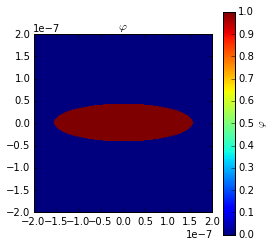

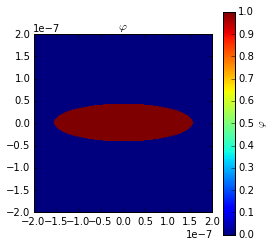

In [37]:
fp.Viewer(vars=phase)

> The total free energy can be written
$$\mathcal{F} = \int \left[f_\mathrm{elastic} + \frac{\kappa}{2}|\nabla \varphi|^2 + h_0 f(\varphi)\right] dV$$
We use a simple interpolation fo the elastic constants
$$C_{ijkl} = h(\varphi) C_{ijkl}^\mathrm{potato}$$
where $h(\varphi)$ is a smooth interpolation function,
$$h(\varphi) = \varphi^3\left[6\varphi^2 - 15\varphi + 10\right]$$
that interpolates between $h(\varphi=0) = 0$ and $h(\varphi=1) = 1$.

> Hint: Find time-evolution equations for $\varphi$ that monotonically drive the total energy to a minimum while preserving the volume. One way to to this is to set up a Cahn-Hilliard equation for $\varphi$.

Our Cahn-Hilliard evolution equation is given by
$$\frac{\partial \varphi}{\partial t} = \nabla\cdot\left(M_\varphi \nabla\frac{\delta \mathcal{F}}{\delta \varphi}\right)$$
where
$$\begin{align*}
\frac{\delta \mathcal{F}}{\delta \varphi} 
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + h_0 \frac{\partial f(\varphi)}{\partial\varphi} \\
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + h_0 \frac{\partial}{\partial\varphi}\left[\varphi^2\left(\varphi - 1\right)^2\right] \\
&= \frac{\partial f_\mathrm{elastic}}{\partial\varphi} - \kappa \nabla^2 \varphi + 2 h_0 \varphi\left(\varphi - 1\right)\left(2\varphi - 1\right)
\end{align*}$$
such that
$$
\begin{align*}
\frac{\partial \varphi}{\partial t} 
&= \nabla\cdot\left(M_\varphi \left\{
\nabla \frac{\partial f_\mathrm{elastic}}{\partial\varphi} + 2 h_0 \left[1 + 6\varphi\left(\varphi - 1\right)\right]\nabla \varphi
- \kappa \nabla^3 \varphi\right\}\right) \\
\frac{1}{M_\varphi}\frac{\partial \varphi}{\partial t} 
&= \nabla^2 \frac{\partial f_\mathrm{elastic}}{\partial\varphi}
+ \nabla\cdot\left\{2 h_0 \left[1 + 6\varphi\left(\varphi - 1\right)\right]\right\}\nabla \varphi
- \kappa \nabla^4 \varphi
\end{align*}$$

Let $M_\mathrm{\varphi} = 1$

In [38]:
Mphase = 1e-19

$$\begin{align*}
f_\mathrm{elastic} &= \frac{1}{2} C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) \\
\frac{\partial f_\mathrm{elastic}}{\partial \varphi} &= \frac{1}{2} \left[ \frac{\partial C_{ijkl}}{\partial \varphi} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
- C_{ijkl} \frac{\partial \epsilon_{ij}^\circ}{\partial \varphi}\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
- C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \frac{\partial \epsilon_{kl}^\circ}{\partial \varphi}\right] \\
&= \frac{1}{2} \left[ -\frac{\partial h(\varphi)}{\partial \varphi} \Delta C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
- \frac{\partial h(\varphi)}{\partial \varphi} C_{ijkl} \epsilon_{ij}^T \left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
- \frac{\partial h(\varphi)}{\partial \varphi} C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \epsilon_{kl}^T\right] \\
&= -\frac{1}{2} \frac{\partial h(\varphi)}{\partial \varphi} \left[ \Delta C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
+ C_{ijkl} \epsilon_{ij}^T \left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
+ C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \epsilon_{kl}^T\right] \\
&= -15 \varphi^2 \left(\varphi - 1\right)^2 \left[ \Delta C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
+ C_{ijkl} \epsilon_{ij}^T \left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
+ C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \epsilon_{kl}^T\right] \\
\end{align*}$$

$$\begin{align*}
\nabla^2\frac{\partial f_\mathrm{elastic}}{\partial \varphi} 
&= \nabla^2\left\{-15 \varphi^2 \left(\varphi - 1\right)^2 \left[ \Delta C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
+ C_{ijkl} \epsilon_{ij}^T \left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
+ C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \epsilon_{kl}^T\right]\right\} \\
&= -30 \varphi \left(\varphi - 1\right) \left(2\varphi - 1\right) \nabla^2 \varphi \left[ \Delta C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
+ C_{ijkl} \epsilon_{ij}^T \left(\epsilon_{kl} - \epsilon_{kl}^\circ\right)
+ C_{ijkl} \left(\epsilon_{ij} - \epsilon_{ij}^\circ\right) \epsilon_{kl}^T\right] \\
&\qquad {}-15 \varphi^2 \left(\varphi - 1\right)^2 \left[
\Delta C_{ijkl}\left(\nabla^2 \epsilon_{ij} - \epsilon_{ij}^T \partial_\varphi h(\varphi) \nabla^2 \varphi\right)
\left(\epsilon_{kl} - \epsilon_{kl}^\circ\right) 
+ \Delta C_{ijkl}\left(\epsilon_{ij} - \epsilon_{ij}^\circ\right)\left(\nabla^2 \epsilon_{kl} - \epsilon_{kl}^T \partial_\varphi h(\varphi) \nabla^2 \varphi\right)
+ \ldots
\right] \\
\end{align*}$$

Too much to figure out. Do explicitly.

In [39]:
PHASE = phase.faceValue

In [40]:
def calc_dfeldphase(elasticstrain):
    return -15 * phase**2 * (phase - 1)**2 * (nmx.einsum('ijkl...,ij...,kl...', C['delta'], elasticstrain, elasticstrain)
                                              + nmx.einsum('ijkl...,ij...,kl...', C['phase'], misfit[...,nmx.newaxis], elasticstrain)
                                               + nmx.einsum('ijkl...,ij...,kl...', C['phase'], elasticstrain, misfit[...,nmx.newaxis]))

In [41]:
dfeldphase = fp.CellVariable(mesh=mesh, name=r"\frac{\partial f_\mathrm{elastic}}{\partial \varphi}")

In [42]:
phaseEq = (fp.TransientTerm(coeff=1./Mphase) 
           == dfeldphase.faceGrad.divergence
           + fp.DiffusionTerm(coeff=2. * h0 * (1. + 6. * PHASE * (PHASE - 1.))) 
           - fp.DiffusionTerm(coeff=(1., kappa)))

In [59]:
phase.value = 0.05
phase.setValue(1.05, where=(mesh.x / 0.155e-6)**2 + (mesh.y / 0.042e-6)**2 <= 1.)

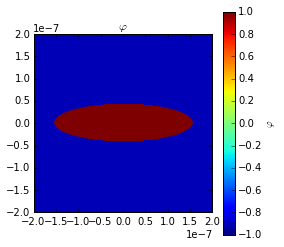

In [55]:
viewer = fp.Viewer(vars=phase) #, datamin=0., datamax=1.)

In [60]:
strainenergy = fp.CellVariable(mesh=mesh, name=r"f_\mathrm{elastic}")

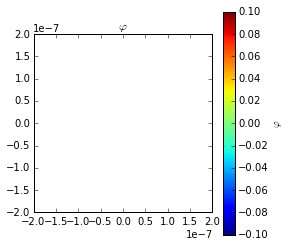

nan
nan
nan


KeyboardInterrupt: 

In [62]:
for step in xrange(1000000):
    print phase.cellVolumeAverage
    
    phase.updateOld()
    for sweep in range(1):
        h_g = calc_h_g(h)
        h2_g = calc_h2_g(h)
        u_g = zerothorder(h_g)
        for iteration in range(1,5):
            u_g = nthorder(u_g, h, h_g, h2_g)
        heterostrain = calc_heterostrain(u_g)
        elasticstrain = calc_elasticstrain(heterostrain)
        elasticstress = calc_elasticstress(elasticstrain)
        dfeldphase.value = calc_dfeldphase(elasticstrain)
        
        res = phaseEq.sweep(var=phase, dt=1.e-6)
        
    strainenergy.value = calc_strainenergy(elasticstrain)
    if step % 10 == 0:
        viewer.plot()
        print strainenergy.cellVolumeAverage